In [63]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Constants
label_title_padding = 10
RECITATION_THRESHOLD = 10

In [2]:
memories_path = "usvsnsp/generation-semantic-filters"
target_split = "pile_deduped_12b"
pile_frame = load_dataset(memories_path, split=target_split).to_pandas()
pile_frame["Memorized"] = pile_frame["memorization_score"] >= 1
print(f"Loaded {len(pile_frame)} examples from {memories_path}/{target_split}")
pile_frame.head(1)

Loaded 5000000 examples from usvsnsp/generation-semantic-filters/pile_deduped_12b


,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,0_8_templates,0_9_templates,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized
0,3195,"[273, 253, 6115, 1159, 275, 5238, 905, 16314, ...",of the Green function in Section \[proof2\].\...,False,False,2,11740996961,1.737210e+09,466618,91844186.5,...,1,1,5.036364,0.0,3195,2.480469,4.364043,2.667871,11.642706,False


In [3]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

pile_frame["Category"] = pile_frame.progress_apply(get_category, axis=1)
pile_frame["Category"].value_counts()

100%|██████████| 5000000/5000000 [00:09<00:00, 511481.16it/s]


Category
Not Memorized     4946005
Recitation          41880
Recollection        11130
Reconstruction        985
Name: count, dtype: int64

In [4]:
pile_frame["is_code"] = pile_frame["nl_scores"].progress_apply(lambda x: x <= 0.45)

100%|██████████| 5000000/5000000 [00:01<00:00, 4732119.83it/s]


generation_perplexity                                          \
                          count      mean       std       min       25%   
Memorized                                                                 
False                 4839838.0  3.419192  1.620504  1.010721  2.333272   
True                    12382.0  1.026164  0.024413  1.000009  1.007694   

                                          
                50%       75%        max  
Memorized                                 
False      3.192831  4.166949  79.729668  
True       1.019247  1.037334   1.200819

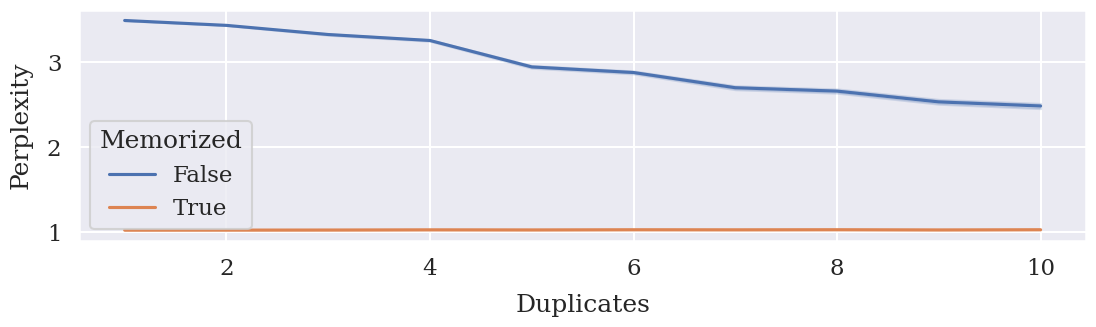

In [5]:
plotting_frame = pile_frame[pile_frame["sequence_duplicates"] <= 10]
display(plotting_frame[["Memorized", "generation_perplexity"]].groupby("Memorized").describe())

# Plot lineplot
sns.lineplot(data=plotting_frame, x="sequence_duplicates", y="generation_perplexity", hue="Memorized", errorbar="ci")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
# plt.xscale("log")

In [6]:
max_memorized_perplexity = plotting_frame[plotting_frame["Memorized"] == False]["generation_perplexity"].quantile(0.99)
max_memorized_perplexity

8.445495252609252

In [7]:
examples_below_ppl_thrrshold = plotting_frame[plotting_frame["generation_perplexity"] <= max_memorized_perplexity]
examples_below_ppl_thrrshold.value_counts("Memorized", normalize=True)

Memorized
False    0.997422
True     0.002578
Name: proportion, dtype: float64

## Memories vs Non-Memories

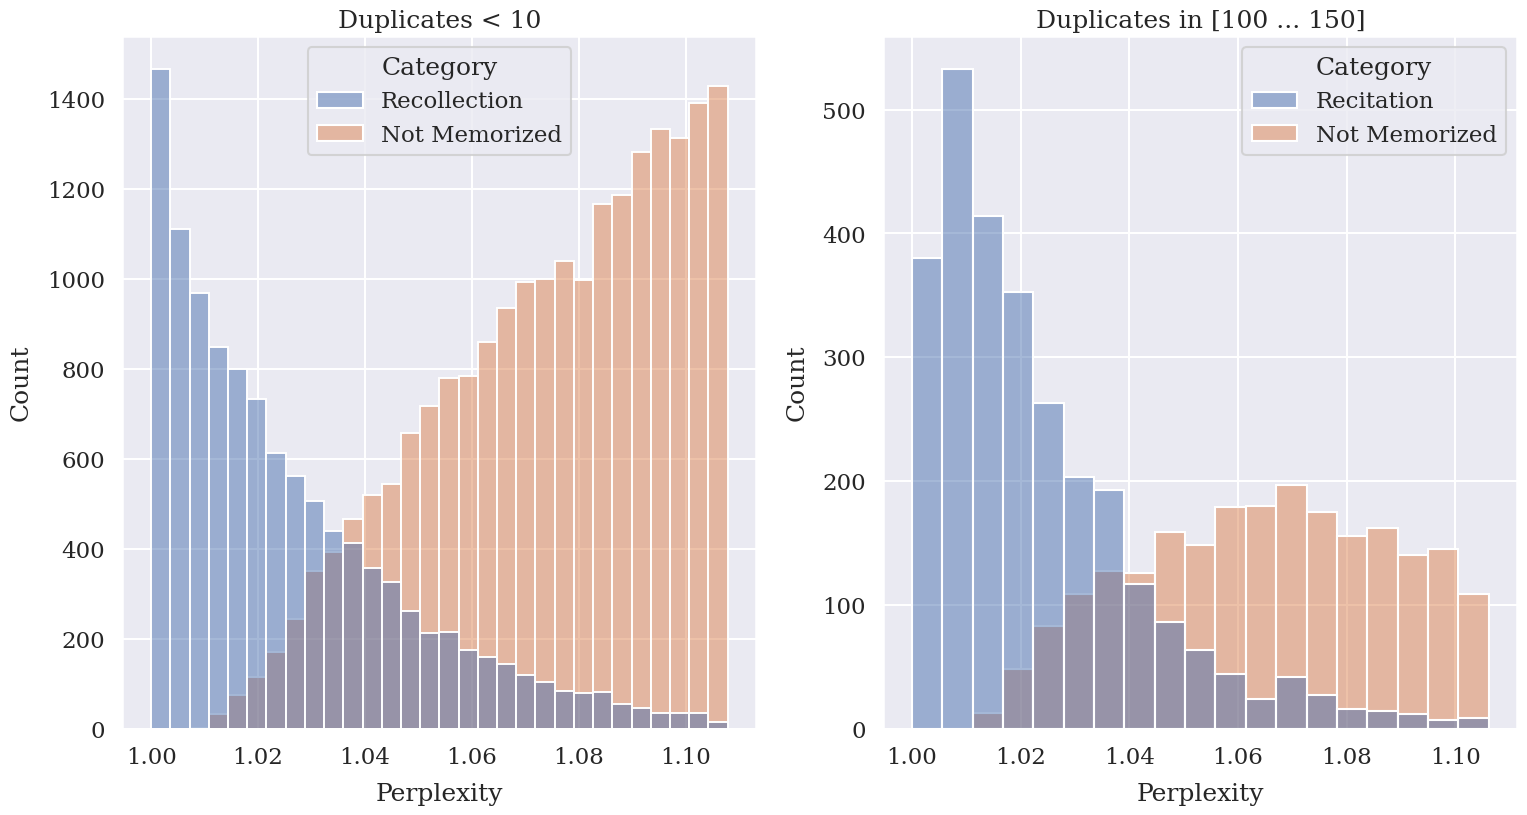

In [8]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames = [
    # duplicates less than 10
    pile_frame[pile_frame["sequence_duplicates"] < 10],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150)]
]

for i, plotting_frame in enumerate(plotting_frames):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Category", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()

## Only Memories by Category

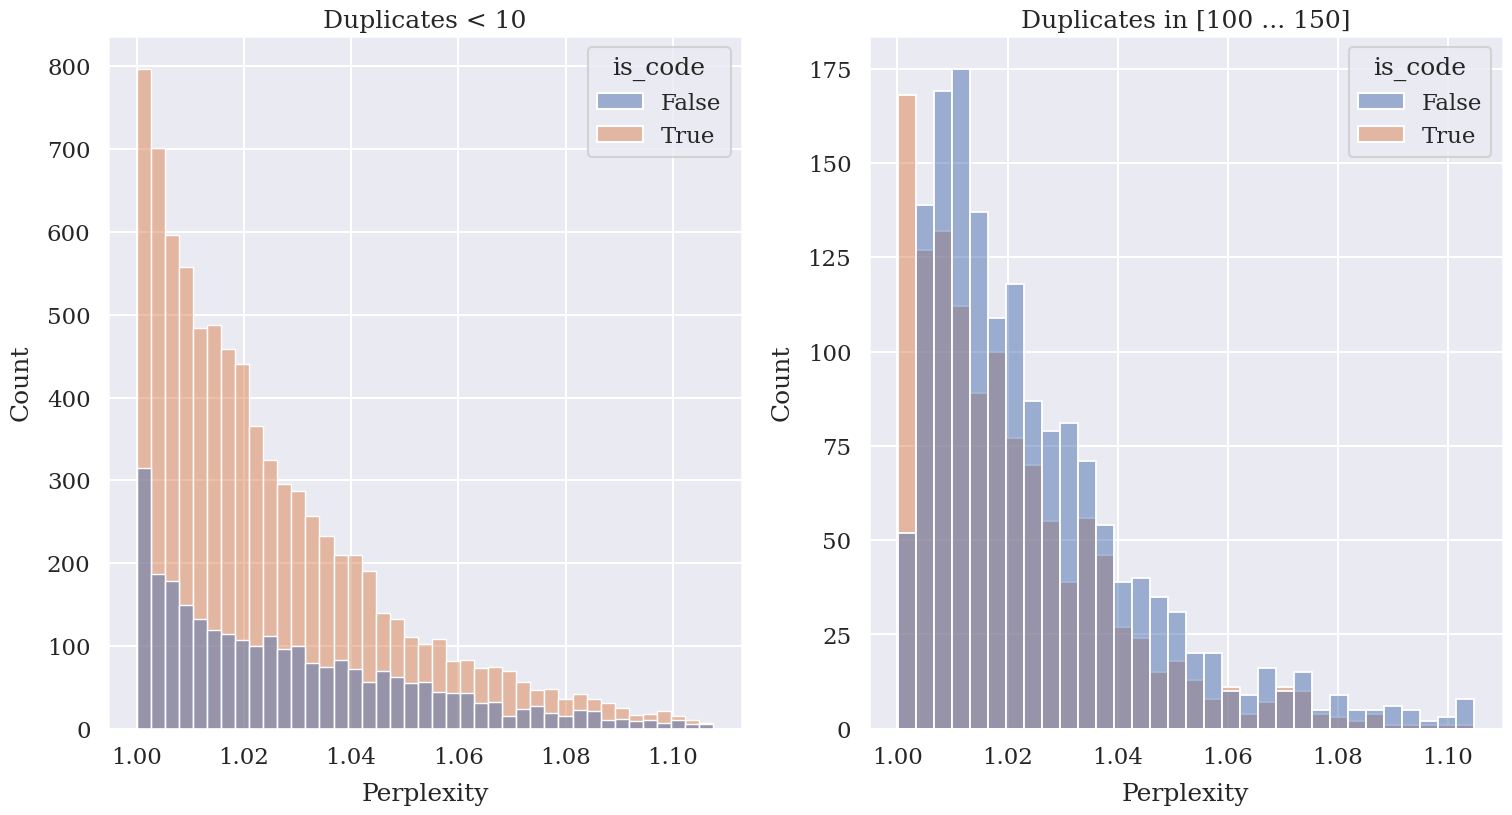

In [9]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames_memorized = [
    # duplicates less than 10
    pile_frame[(pile_frame["sequence_duplicates"] < 10) & (pile_frame["Memorized"] == True)],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150) & (pile_frame["Memorized"] == True)]
]

for i, plotting_frame in enumerate(plotting_frames_memorized):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="is_code", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()

## Memories vs Non-Memories by Dataset

In [10]:
memories_dataset = load_dataset(memories_path, split="memories_deduped_12b").to_pandas()
memories_dataset["Memorized"] = True
memories_dataset.head()

,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,0_8_templates,0_9_templates,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized
0,15064,"[29, 965, 31, 12641, 64, 56, 1838, 9278, 64, 1...",<li>ERROR_WIDGET_DISPOSED - if the receiver ha...,False,False,700,11740996961,9.946212e+08,527839,271847545.0,...,0,0,5.044444,1.0,15064,0.532715,2.064291,1.006569,2.077852,True
1,21590,"[12231, 3, 1416, 568, 79, 12231, 1138, 12231, ...","117"" name=""n117"">117</a>\n<a href=""#n118"" name...",False,False,56,11740996961,9.443266e+08,3053059,277329702.0,...,9,3,4.588235,1.0,21590,0.705078,1.430392,1.002014,1.433272,True
2,30252,"[50276, 17490, 15, 2490, 50276, 15781, 15, 249...",203. \n 204. \n 205. \n 206. \n 207. \n ...,True,False,21827,10346382453,2.779838e+09,2205998,385281005.0,...,7,0,3.000000,1.0,30252,0.595703,1.205198,1.000322,1.205586,True
3,35232,"[13815, 27, 52, 2320, 1792, 15, 187, 187, 53, ...",Mac:Safari.\n\nTripAdvisor LLC is not responsi...,False,False,22219,11740996961,1.964035e+09,1623266,30358136.0,...,9,0,4.592000,1.0,35232,0.596191,1.073433,1.006160,1.080046,True
4,66319,"[187, 187, 2621, 13, 8529, 15, 416, 15, 2051, ...","\n\norder, Fed. R. App. P. 4(a)(1)(B), unless ...",False,False,177,11740996961,3.694662e+09,4445067,187639943.5,...,6,1,4.684211,1.0,66319,0.646484,1.856300,1.024656,1.902068,True


In [11]:
all_memories_and_sample = pd.concat([
    pile_frame[pile_frame["Memorized"] == False],
    memories_dataset]
    ).drop_duplicates(subset=["sequence_id"])

In [12]:
all_memories_and_sample["Memorized"].value_counts()

Memorized
False    4946005
True     1871215
Name: count, dtype: int64

In [15]:
all_memories_plotting_frames = [
    all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] < 10],
    all_memories_and_sample[(all_memories_and_sample["sequence_duplicates"] >= 100) & (all_memories_and_sample["sequence_duplicates"] <= 150)]
]

all_memories_plotting_frames[0].head(1)

,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized,Category,is_code
0,3195,"[273, 253, 6115, 1159, 275, 5238, 905, 16314, ...",of the Green function in Section \[proof2\].\...,False,False,2,11740996961,1.737210e+09,466618,91844186.5,...,5.036364,0.0,3195,2.480469,4.364043,2.667871,11.642706,False,Not Memorized,False


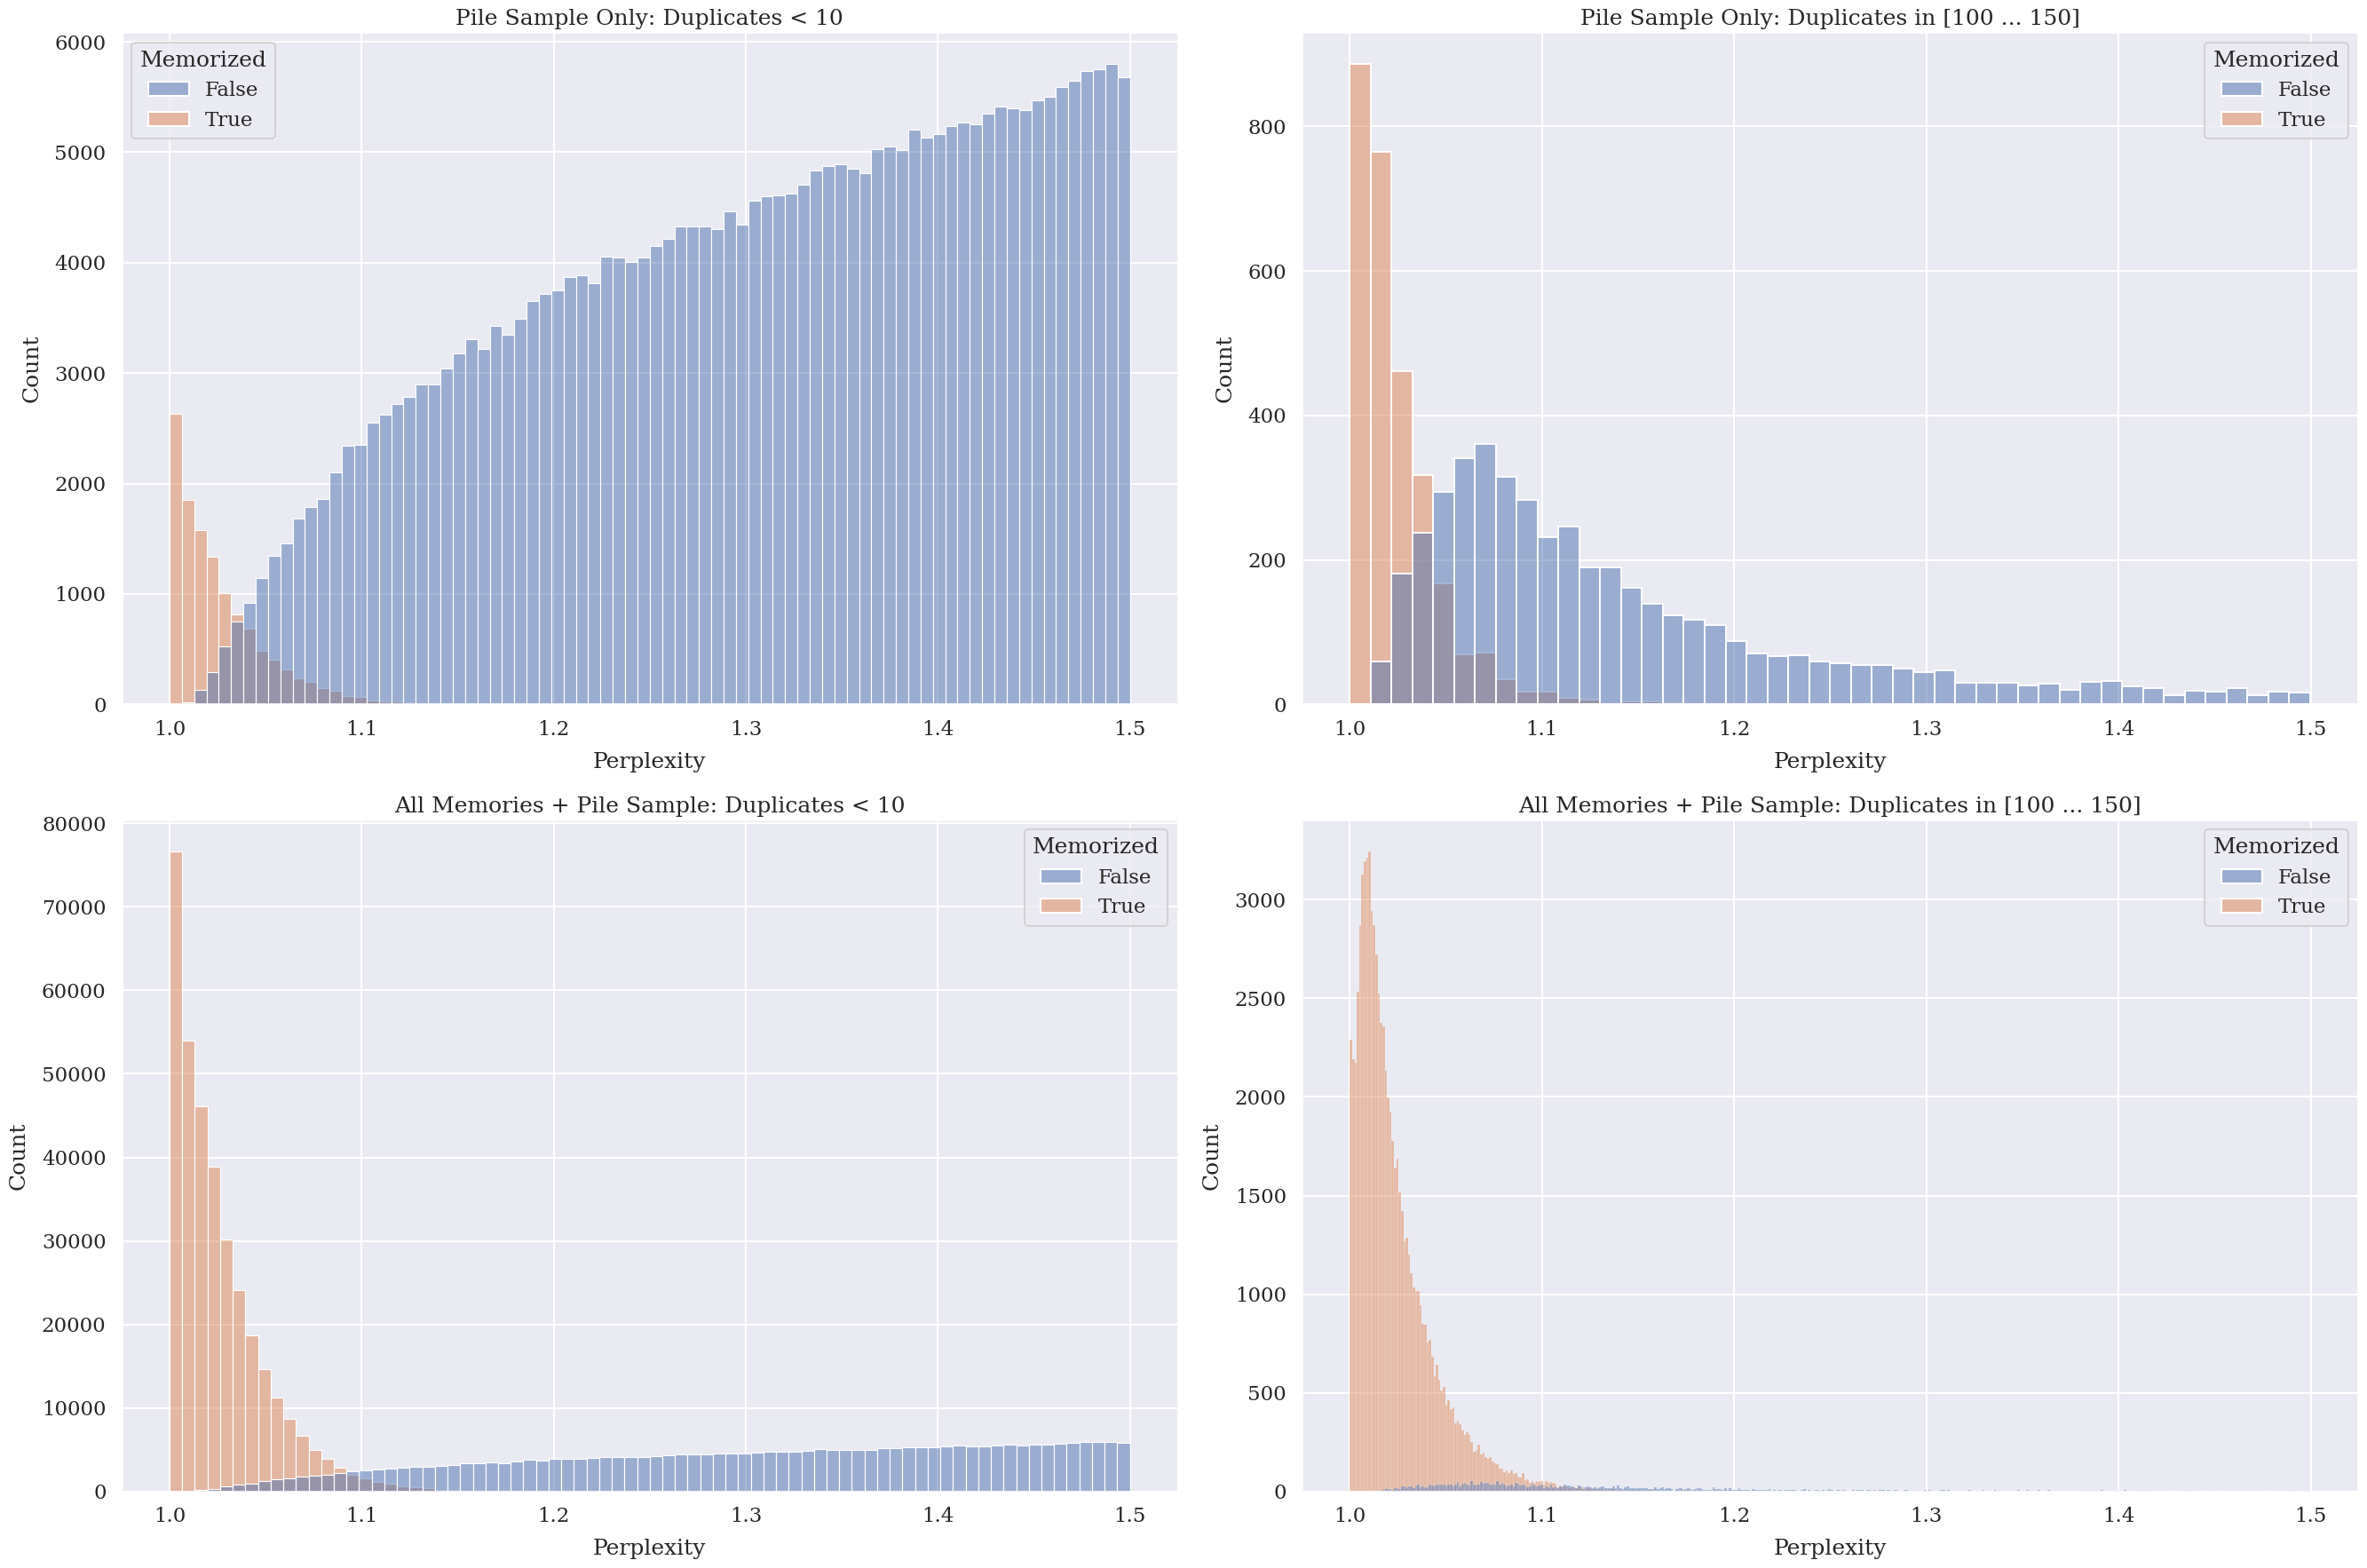

In [14]:
# TWO HISTOGRAMS across two rows
fig, ax = plt.subplots(2, 2, figsize=(27, 18))



for row_index in range(2):
    for col_index, plotting_frame in enumerate(plotting_frames if row_index == 0 else all_memories_plotting_frames):
        # p95_mem_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.95)
        p95_mem_ppl = 1.5
        hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_mem_ppl]

        # hist should be transparent to show both
        sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Memorized", multiple="layer", ax=ax[row_index, col_index])

        # Set Labels
        ax[row_index, col_index].set_xlabel("Perplexity", labelpad=label_title_padding)
        ax[row_index, col_index].set_ylabel("Count", labelpad=label_title_padding)

        # Set centered row titles. First row is "Pile Sample Only" and second row is "All Memories + Pile Sample"
        title_prefix = ""
        if row_index == 0:
            title_prefix = "Pile Sample Only:"
        else:
            title_prefix = "All Memories + Pile Sample:"

        # set titles
        if col_index == 0:
            ax[row_index, col_index].set_title(f"{title_prefix} Duplicates < 10")
        else:
            ax[row_index, col_index].set_title(f"{title_prefix} Duplicates in [100 ... 150]")

# add padding
plt.tight_layout()

## KL Divergence

In [116]:
from scipy.stats import entropy

In [117]:
# bucket sequence duplicates in buckets of 5 by rounding down
pile_frame_rounded = pile_frame.copy()
bin_size = 1
pile_frame_rounded["sequence_duplicates"] = pile_frame_rounded["sequence_duplicates"].apply(lambda x: x - (x % bin_size))
pile_frame_rounded["sequence_duplicates"].value_counts().sort_index()

sequence_duplicates
1          1324363
2          3082552
3           148861
4           162744
5            40383
            ...   
4291073         84
4291074         74
4291076         82
4291088         62
5480569         70
Name: count, Length: 9760, dtype: int64

100%|██████████| 1000/1000 [00:06<00:00, 163.54it/s]


,Duplicates,KL Divergence
0,1,0.113385
1,2,0.113264
2,3,0.167163
3,4,0.171921
4,5,0.184402


,Duplicates,KL Divergence
0,1,0.110483
1,2,0.110064
2,3,0.160421
3,4,0.166235
4,5,0.185701


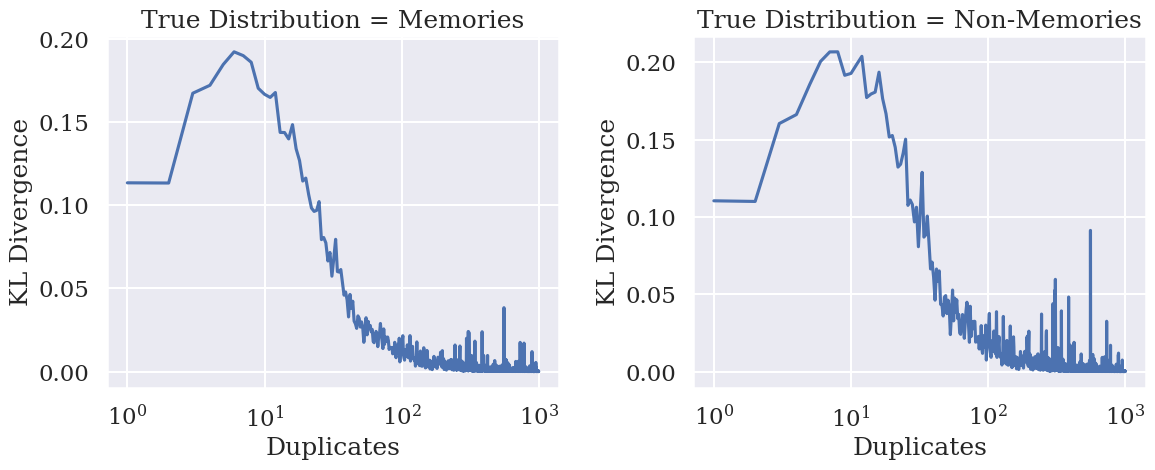

In [127]:
memory_divergences = []
nonmemory_divergences = []
duplications= np.arange(0, 1000, bin_size)
for duplication_count in tqdm(duplications):
    if duplication_count == 0:
        continue

    examples_at_duplication_count = all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] == duplication_count]
    memories_at_duplication_count = memories_dataset[memories_dataset["sequence_duplicates"] == duplication_count]["generation_perplexity"]
    non_memories_at_duplication_count = all_memories_and_sample[all_memories_and_sample["sequence_duplicates"] == duplication_count]["generation_perplexity"]
    
    # downsample to calculate kl divergence
    balance_size = min(len(memories_at_duplication_count), len(non_memories_at_duplication_count))
    memories_at_duplication_count = memories_at_duplication_count.sample(balance_size)
    non_memories_at_duplication_count = non_memories_at_duplication_count.sample(balance_size)

    # generate kl divergence in perplexity with memories as the true distribution
    kl_divergence = entropy(memories_at_duplication_count, non_memories_at_duplication_count)
    memory_divergences.append({
        "Duplicates": duplication_count,
        "KL Divergence": kl_divergence
    })

    # generate kl divergence in perplexity with non-memories as the true distribution
    kl_divergence = entropy(non_memories_at_duplication_count, memories_at_duplication_count)
    nonmemory_divergences.append({
        "Duplicates": duplication_count,
        "KL Divergence": kl_divergence
    })

memory_divergences_frame = pd.DataFrame(memory_divergences)
nonmemory_divergences_frame = pd.DataFrame(nonmemory_divergences)

head_size = 5
display(memory_divergences_frame.head(head_size))
display(nonmemory_divergences_frame.head(head_size))

# plot both frames
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(data=memory_divergences_frame, x="Duplicates", y="KL Divergence", ax=ax[0])
ax[0].set_title("True Distribution = Memories")

sns.lineplot(data=nonmemory_divergences_frame, x="Duplicates", y="KL Divergence", ax=ax[1])
ax[1].set_title("True Distribution = Non-Memories")

# add padding
plt.tight_layout()

# log x axis
ax[0].set_xscale("log")
ax[1].set_xscale("log")

fig.savefig("figures/kl_divergence_generation_ppl.pdf")

In [122]:
plotting_frames[0][plotting_frames[0]["sequence_duplicates"] == 3]

,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized,Category,is_code
21,107139,"[61, 282, 20, 889, 565, 578, 46, 578, 1944, 49...",\le3}\int_{M_{ij}}(w_j-w_i)\cdot n_{ij}d\mathc...,False,False,3,2965935634,3.828344e+08,9204326,144154935.0,...,4.862069,0.31250,107139,2.718750,3.217046,1.393496,4.482942,False,Not Memorized,True
32,138177,"[4331, 7663, 985, 13, 2097, 403, 2530, 534, 21...","pen recording system, means are provided whic...",False,False,3,10346382453,1.607807e+09,1275887,43201861.0,...,4.560440,0.00000,138177,2.480469,4.321364,3.675777,15.884372,False,Not Memorized,False
37,163903,"[2756, 187, 33249, 18746, 3481, 46063, 13, 502...","\n\n\n\nUNITED STATES OF AMERICA, ...",False,False,3,11740996961,2.553283e+09,426546,162176959.5,...,4.492424,0.78125,163903,2.472656,1.366662,1.297131,1.772739,False,Not Memorized,False
137,540541,"[15, 6915, 247, 23186, 273, 36480, 434, 4707, ...",". Using a strand of Superman's hair, Luthor sy...",False,False,3,10346382453,1.636530e+09,667444,13927543.0,...,4.896552,0.03125,540541,2.531250,4.054323,3.955898,16.038488,False,Not Memorized,False
250,1024774,"[6326, 281, 320, 14142, 28, 452, 731, 1918, 47...",supposed to be actors; have them give me any ...,False,False,3,10346382453,1.263996e+09,420646,194025157.0,...,4.669355,0.00000,1024774,2.503906,3.353115,4.501162,15.092916,False,Not Memorized,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999888,142908481,"[310, 327, 937, 346, 42, 3078, 281, 1056, 2119...","is on,"" ""I wanted to make sure you still coun...",False,False,3,8485755698,1.290962e+09,1804229,129253475.0,...,4.511811,0.09375,142908481,2.654297,4.108484,4.750322,19.516623,False,Not Memorized,False
4999905,143470282,"[26650, 15, 831, 14000, 556, 1652, 390, 642, 1...",musician. This adjustment has little or no ef...,False,False,3,11740996961,3.130208e+09,1148025,242403252.0,...,4.664234,0.03125,143470282,2.363281,5.520488,2.651811,14.639289,False,Not Memorized,False
4999933,144253637,"[807, 15, 2058, 15184, 8522, 284, 457, 18066, ...","year. At Lagunitas’ festive beer garden, gues...",False,False,3,10346382453,1.522495e+09,963324,33447384.0,...,4.868613,0.06250,144253637,2.603516,3.256384,4.178623,13.607199,False,Not Memorized,False
4999952,144754630,"[2053, 15517, 1336, 2406, 253, 3276, 273, 2133...",These catheters lower the temperature of body...,False,False,3,11740996961,2.745213e+09,546835,48343051.0,...,4.585799,0.03125,144754630,2.558594,3.470643,3.882236,13.473856,False,Not Memorized,False


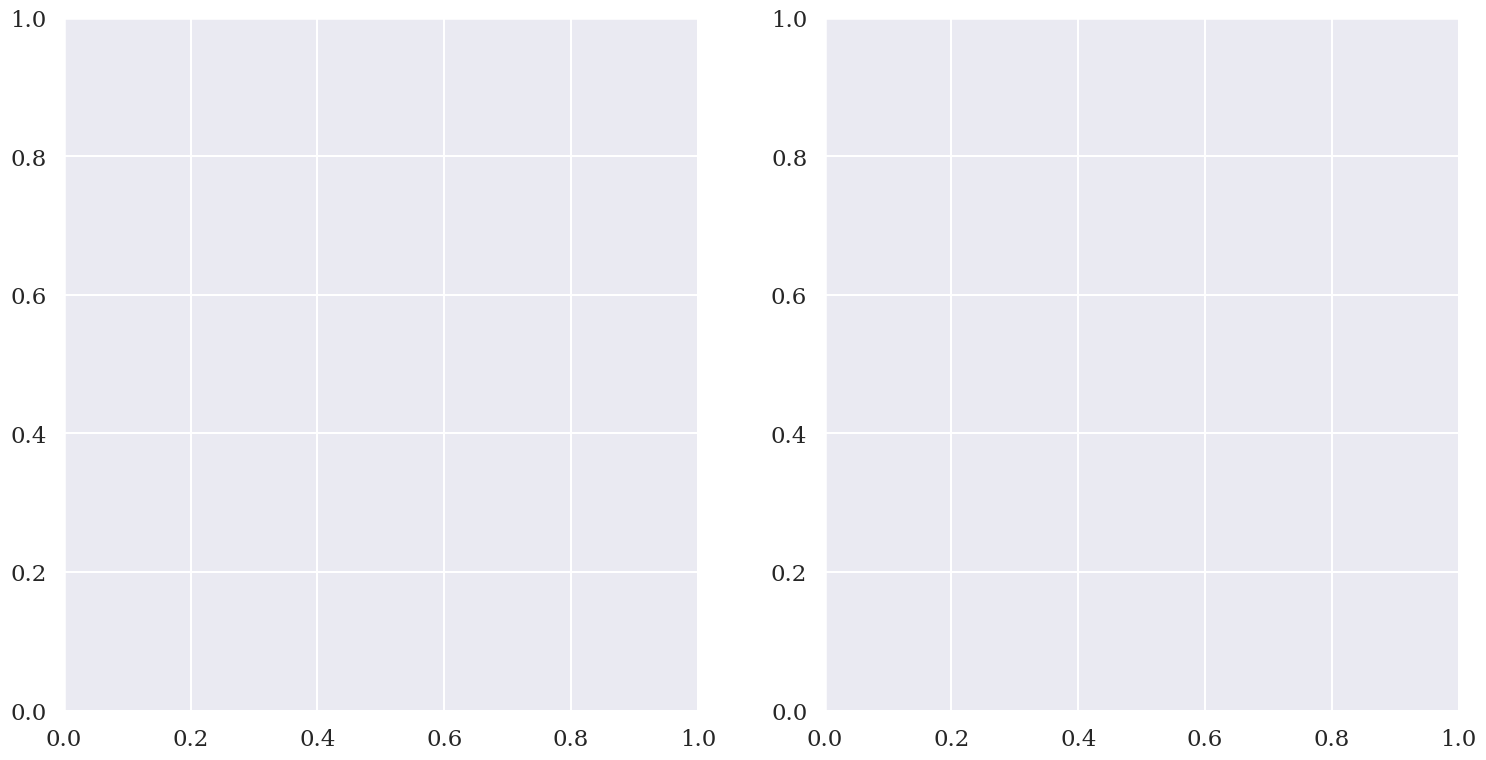

In [123]:
# plot the kl divergence in perplexity
fig, ax = plt.subplots(1, 2, figsize=(18, 9))